## Set up the Spark environment and import libraries

In [2]:
%%configure -f \
{"conf": {"spark.jars.packages": "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.2"}}

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 28, -1, Finished, Available)

Unrecognized options: 

In [3]:
spark

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 28, 6, Finished, Available)

In [4]:
! pip install spark-nlp

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 28, 7, Finished, Available)

     |████████████████████████████████| 540 kB 9.3 MB/s eta 0:00:01


In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, when, broadcast, udf, explode, length
from pyspark.sql.types import StringType, IntegerType
import sparknlp
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import UniversalSentenceEncoder, SentimentDLModel
from sparknlp.pretrained import PretrainedPipeline

# Set up data configuration
blob_account_name = "marckvnonprodblob"
blob_container_name = "bigdata"
blob_sas_token = "?sv=2021-10-04&st=2023-10-04T01%3A42%3A59Z&se=2024-01-02T02%3A42%3A00Z&sr=c&sp=rlf&sig=w3CH9MbCOpwO7DtHlrahc7AlRPxSZZb8MOgS6TaXLzI%3D"


wasbs_base_url = (
    f"wasbs://{blob_container_name}@{blob_account_name}.blob.core.windows.net/"
)
spark.conf.set(
    f"fs.azure.sas.{blob_container_name}.{blob_account_name}.blob.core.windows.net",
    blob_sas_token,
)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 28, 8, Finished, Available)

## Read in the Reddit data

In [6]:
submissions_path = "reddit-parquet/submissions/"
submissions_df = spark.read.parquet(f"{wasbs_base_url}{submissions_path}")

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 28, 9, Finished, Available)

## Create and process the eSports Events DataFrame

In [7]:
# Define the schema for the events data
from pyspark.sql.types import StructType, StructField, DateType
from datetime import datetime
from pyspark.sql import Row

schema = StructType([
    StructField("game", StringType(), True),
    StructField("event_name", StringType(), True),
    StructField("start_date", DateType(), True),
    StructField("end_date", DateType(), True)
])

# eSports events
eSportsEventsData = [
    {"game": "League of Legends", "event_name": "World Championship", "start_date": "2021-10-05", "end_date": "2021-11-06"},
    {"game": "League of Legends", "event_name": "Mid-Season Invitational", "start_date": "2021-05-06", "end_date": "2021-05-22"},
    {"game": "Valorant", "event_name": "Champions Tour", "start_date": "2021-12-01", "end_date": "2021-12-12"},
    {"game": "Dota 2", "event_name": "The International", "start_date": "2021-08-05", "end_date": "2021-08-15"},
    {"game": "Valorant", "event_name": "Masters", "start_date": "2022-04-10", "end_date": "2022-04-24"},
    {"game": "Dota 2", "event_name": "Major Championship", "start_date": "2022-05-02", "end_date": "2022-05-14"},
    {"game": "League of Legends", "event_name": "Summer Split", "start_date": "2022-06-04", "end_date": "2022-09-05"},
    {"game": "Valorant", "event_name": "Red Bull Campus Clutch", "start_date": "2022-07-17", "end_date": "2022-07-18"},
    {"game": "Dota 2", "event_name": "Winter Championship", "start_date": "2023-01-08", "end_date": "2023-01-23"},
    {"game": "League of Legends", "event_name": "Spring Split", "start_date": "2023-01-14", "end_date": "2023-04-19"},
    {"game": "Valorant", "event_name": "VCT Stage 1 Masters", "start_date": "2023-03-10", "end_date": "2023-03-20"}
]

# Convert date strings to date objects in Python before creating the DataFrame
def convert_dates(event):
    event['start_date'] = datetime.strptime(event['start_date'], '%Y-%m-%d').date()
    event['end_date'] = datetime.strptime(event['end_date'], '%Y-%m-%d').date()
    return event

eSportsEventsData = [convert_dates(event) for event in eSportsEventsData]

# Create a DataFrame from the list of dictionaries
eSportsEventsDF = spark.createDataFrame(eSportsEventsData)

# Show the Esports DataFrame
eSportsEventsDF.show()

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 28, 10, Finished, Available)

+----------+--------------------+-----------------+----------+
|  end_date|          event_name|             game|start_date|
+----------+--------------------+-----------------+----------+
|2021-11-06|  World Championship|League of Legends|2021-10-05|
|2021-05-22|Mid-Season Invita...|League of Legends|2021-05-06|
|2021-12-12|      Champions Tour|         Valorant|2021-12-01|
|2021-08-15|   The International|           Dota 2|2021-08-05|
|2022-04-24|             Masters|         Valorant|2022-04-10|
|2022-05-14|  Major Championship|           Dota 2|2022-05-02|
|2022-09-05|        Summer Split|League of Legends|2022-06-04|
|2022-07-18|Red Bull Campus C...|         Valorant|2022-07-17|
|2023-01-23| Winter Championship|           Dota 2|2023-01-08|
|2023-04-19|        Spring Split|League of Legends|2023-01-14|
|2023-03-20| VCT Stage 1 Masters|         Valorant|2023-03-10|
+----------+--------------------+-----------------+----------+



## Filter the Reddit data to focus on the relevant subreddits

In [8]:
subreddits = ["summonerschool", "leagueoflegends", "LeagueOfMemes", "lolesports", 
              "VALORANT", "ValorantCompetitive", "AgentAcademy", "ValorantMemes", 
              "DotA2"]

submissions_filtered = submissions_df.filter(col("subreddit").isin(subreddits))

submissions_filtered.show(10)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 28, 11, Finished, Available)

+------------------+------------------+--------+-------------------+--------------+----------------------+--------------------+---------+----------+------------+-------------------+----------------+---------------------+----------------+-------------+--------------------+---------------+-------------+----------+---------+------+------+----------+--------+-------+---------+----------------+----------------------+-------+--------+--------------------+---------------+------+--------------------+--------------------+-------------+------------+--------------+-------------+-------+-----------------------+--------------------+------+------------+--------------------+--------+-----------+---------------------+------------+-------------------+-----+--------------------+--------------------+--------------------+-------+--------+-------------------+------------+--------------+--------------------+--------------------+----------------------+--------------------+----------------+---------------+---

## Integrate the eSports Events with the Reddit Posts

In [9]:
# Convert timestamps to dates for comparison
submissions_filtered = submissions_filtered.withColumn("post_date", to_date(col("created_utc"), "yyyy-MM-dd"))

condition = (col("post_date") >= col("start_date")) & (col("post_date") <= col("end_date"))

submissions_during_events = submissions_filtered.join(
    broadcast(eSportsEventsDF),
    condition,
    "left_outer"
)

submissions_during_events = submissions_during_events.withColumn(
    "during_event",
    when(col("event_name").isNotNull(), 1).otherwise(0)
)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 28, 12, Finished, Available)

In [10]:
submissions_during_events.show(6)

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 28, 13, Finished, Available)

+------------------+------------------+--------+------------------+--------------+----------------------+-----------------+---------+----------+------------+-------------------+----------------+---------------------+----------------+-------------+-------------+---------------+-------------+----------+---------+------+------+----------+--------+-------+---------+----------------+----------------------+-------+--------+--------------------+---------------+------+--------------------+--------------------+-------------+------------+--------------+-------------+-------+-----------------------+--------------------+------+------------+--------------------+--------+-----------+---------------------+------------+-------------------+-----+--------------------+--------------------+--------------------+-------+--------+-------------------+------------+--------------+--------------------+--------------------+----------------------+--------------------+----------------+---------------+--------------

## Perform Sentiment Analysis

In [11]:
import pandas as pd
import numpy as np
import json
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import sparknlp
from sparknlp.annotator import *
from sparknlp.base import *
from sparknlp.pretrained import PretrainedPipeline

# Build the Spark NLP pipeline for sentiment analysis
document_assembler = DocumentAssembler()\
    .setInputCol("selftext")\
    .setOutputCol("document")

use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
    .setInputCols(["document"])\
    .setOutputCol("sentence_embeddings")

sentimentdl = SentimentDLModel.pretrained(name="sentimentdl_use_twitter", lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlp_pipeline = Pipeline(
    stages=[
        document_assembler,
        use,
        sentimentdl
    ]
)


StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 28, 14, Finished, Available)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]


In [12]:
# Prepare the data for the sentiment model, selecting only necessary columns
df_post = submissions_during_events.select(
    col("subreddit"),
    col("selftext"), 
    col("during_event")
).filter(length(col("selftext")) > 0)

# Fit and run the pipeline
senti_model = nlp_pipeline.fit(df_post)
senti_pred = senti_model.transform(df_post)

# Extract sentiment results and count them
df_senti = senti_pred.select(
    "subreddit",
    "during_event",
    F.explode('sentiment.result').alias('sentiment')
)
df_senti_count = df_senti.groupBy("subreddit", "during_event", "sentiment").count()


StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 28, 15, Finished, Available)

## Visualization

In [15]:
# Convert the sentiment count DataFrame to Pandas for visualization
df_senti_count_pd = df_senti_count.toPandas()

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 28, 18, Finished, Available)

In [16]:
df_senti_count_pd

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 28, 19, Finished, Available)

,subreddit,during_event,sentiment,count
0,summonerschool,1,positive,1932
1,ValorantMemes,0,negative,1819
2,DotA2,1,positive,10489
3,DotA2,0,negative,80414
4,ValorantMemes,1,negative,917
5,leagueoflegends,1,neutral,1246
6,AgentAcademy,1,positive,411
7,summonerschool,0,neutral,178
8,lolesports,0,negative,766
9,AgentAcademy,1,neutral,38


In [17]:
# Combine the counts of different subreddits based on the game type (League of Legends, Valorant, Dota 2)
# Mapping of subreddits to their respective game types
game_type_mapping = {
    'summonerschool': 'League of Legends',
    'leagueoflegends': 'League of Legends',
    'LeagueOfMemes': 'League of Legends',
    'lolesports': 'League of Legends',
    'LeagueConnect': 'League of Legends',
    'VALORANT': 'Valorant',
    'ValorantCompetitive': 'Valorant',
    'AgentAcademy': 'Valorant',
    'ValorantMemes': 'Valorant',
    'DotA2': 'Dota 2'
}

# Create a new column in the DataFrame for game type
df_senti_count_pd['game_type'] = df_senti_count_pd['subreddit'].map(game_type_mapping)

# Group by game type and sentiment, then combine counts
grouped_df = df_senti_count_pd.groupby(['game_type', 'sentiment']).agg({'count': 'sum'}).reset_index()

# Pivot the grouped data for better visualization
pivot_df = grouped_df.pivot(index='game_type', columns='sentiment', values='count').fillna(0)

# Analysis based on the combined data
pivot_df['total'] = pivot_df.sum(axis=1)
pivot_df['positive_ratio'] = pivot_df['positive'] / pivot_df['total']
pivot_df['negative_ratio'] = pivot_df['negative'] / pivot_df['total']
pivot_df['neutral_ratio'] = pivot_df['neutral'] / pivot_df['total']

pivot_df[['positive_ratio', 'negative_ratio', 'neutral_ratio']]

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 28, 20, Finished, Available)

sentiment,positive_ratio,negative_ratio,neutral_ratio
game_type,,,
Dota 2,0.195275,0.773087,0.031637
League of Legends,0.130243,0.858494,0.011263
Valorant,0.121228,0.866721,0.012050


StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 28, 24, Finished, Available)

/home/trusted-service-user/cluster-env/env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/trusted-service-user/cluster-env/env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


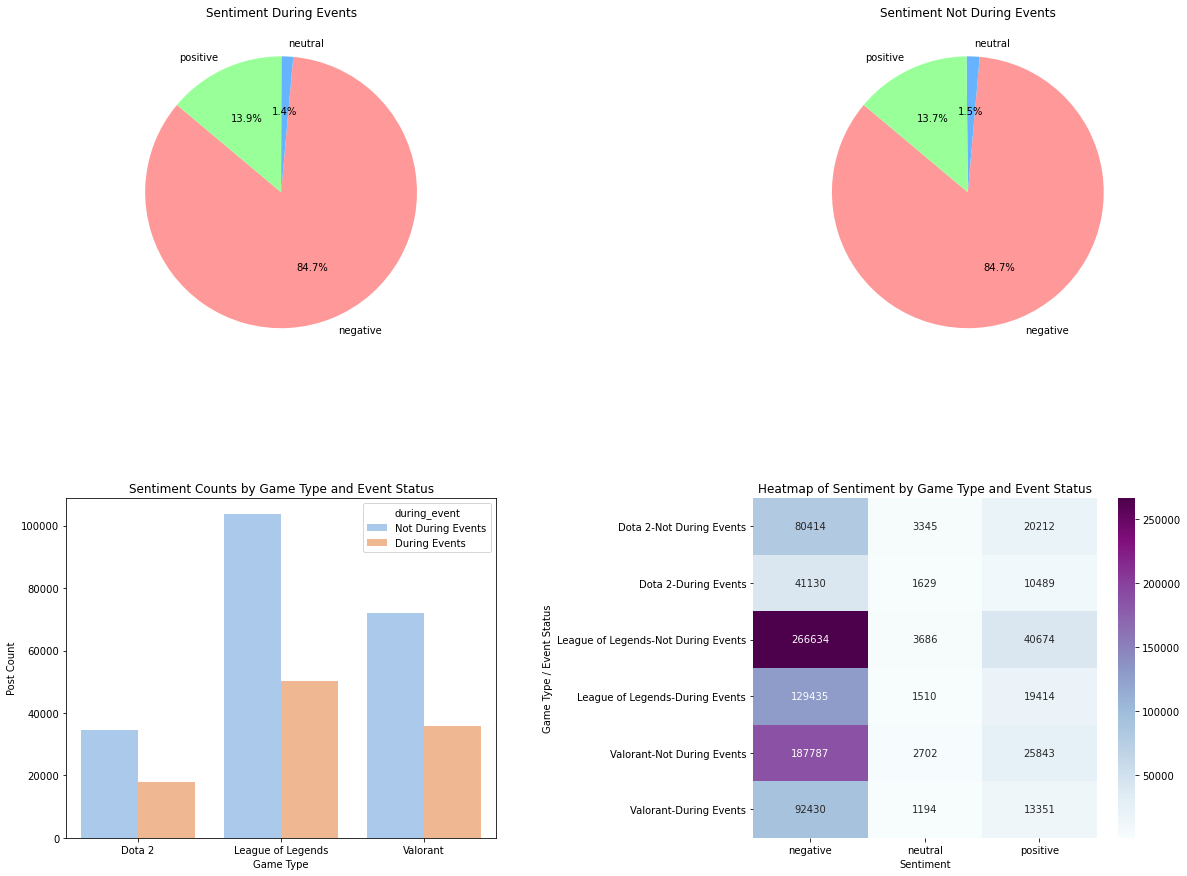

<Figure size 432x288 with 0 Axes>

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the aesthetic style of the plots
sns.set_palette("pastel")

# Create subplots for the visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()  # Flatten the array for easy iteration
plt.subplots_adjust(hspace=0.4, wspace=0.6)

# Pie chart for overall sentiment distribution during and not during events
overall_sentiment = df_senti_count_pd.groupby(['during_event', 'sentiment'])['count'].sum().reset_index()
during_event_sentiment = overall_sentiment[overall_sentiment['during_event'] == 1]
not_during_event_sentiment = overall_sentiment[overall_sentiment['during_event'] == 0]

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
during_event_sentiment.set_index('sentiment').plot.pie(
    y='count', 
    autopct='%1.1f%%', 
    startangle=140, 
    ax=axes[0], 
    colors=colors,
    legend=False
)
axes[0].set_ylabel('')
axes[0].set_title('Sentiment During Events')

not_during_event_sentiment.set_index('sentiment').plot.pie(
    y='count', 
    autopct='%1.1f%%', 
    startangle=140, 
    ax=axes[1], 
    colors=colors,
    legend=False
)
axes[1].set_ylabel('')
axes[1].set_title('Sentiment Not During Events')

# Bar chart for sentiment counts by game type, distinguished by during/not during events
grouped_bar_data = df_senti_count_pd.groupby(['game_type', 'during_event', 'sentiment'])['count'].sum().unstack(fill_value=0).reset_index()
grouped_bar_data['during_event'] = grouped_bar_data['during_event'].map({0: 'Not During Events', 1: 'During Events'})
sns.barplot(
    x='game_type', 
    y='count', 
    hue='during_event', 
    data=grouped_bar_data.melt(id_vars=['game_type', 'during_event'], var_name='sentiment', value_name='count'), 
    ax=axes[2],
    ci=None  # No error bars
)
axes[2].set_title('Sentiment Counts by Game Type and Event Status')
axes[2].set_xlabel('Game Type')
axes[2].set_ylabel('Post Count')

# Heatmap for sentiment by game type and event status
heatmap_data = df_senti_count_pd.groupby(['game_type', 'during_event', 'sentiment'])['count'].sum().unstack(fill_value=0)
heatmap_data.index = pd.MultiIndex.from_tuples([(i, 'During Events' if j == 1 else 'Not During Events') for i, j in heatmap_data.index], names=['Game Type', 'Event Status'])
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='BuPu', ax=axes[3])
axes[3].set_title('Heatmap of Sentiment by Game Type and Event Status')
axes[3].set_xlabel('Sentiment')
axes[3].set_ylabel('Game Type / Event Status')

# Show all plots
plt.show()

# Save the plots
plt.savefig('Users/nj417/fall-2023-reddit-project-team-11/img/esports_sentiment_analysis_plots.png')


Analysis:
Sentiment During Events (Pie Chart): The pie chart provides a clear visual representation of sentiment proportions during events. Negative sentiment takes the largest share, indicating a trend towards critical discussions when events are happening.

Sentiment Not During Events (Pie Chart): Similarly, the pie chart for periods not during events also shows that negative sentiments are prevalent, although the distribution is slightly different from the event period, suggesting a change in community behavior in response to events.

Sentiment Counts by Game Type (Bar Chart): This bar chart presents a side-by-side comparison of sentiments for each game type, distinguishing between periods during and not during events. It's evident that negative sentiment is heightened during events for all game types, with Valorant showing the most significant increase.

Heatmap of Sentiment by Game Type and Event Status: The heatmap offers a detailed breakdown of post counts by sentiment, game type, and event status. The darker shades represent higher post counts, with negative sentiment during events being particularly pronounced.

## Save the Processed Data

In [22]:
workspace_default_storage_account = "group11astorage9fbe30595"
workspace_default_container = "azureml-blobstore-6f372cc8-8edb-4b30-ad9f-73d38eb592f4"

workspace_wasbs_base_url = (
    f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/")
    

# save
senti_pred.write.mode("overwrite").parquet(f"{workspace_wasbs_base_url}Users/nj417/fall-2023-reddit-project-team-11/data/esports_sentiment_analysis.parquet")

StatementMeta(3c67b279-1d53-4b7a-b0d9-41cb8b4b6723, 28, 25, Finished, Available)

## Report

In this project, we embarked on a comprehensive data analysis to explore the impact of eSports events on the sentiment and engagement of players within related online communities (Reddit). Our approach was methodical and multifaceted, leveraging advanced data processing and natural language processing (NLP) capabilities provided by Spark and Spark NLP within an Azure environment.

Initial Setup and Data Configuration:
We began by configuring the Spark environment tailored for Azure's storage system to access the Reddit data. This involved setting up the SparkSession, including Spark NLP libraries and ensuring that the necessary configurations for accessing the blob storage were in place.

Data Preparation:
Subsequent to the setup, we focused on ingesting the Reddit submissions dataset, which was filtered to include posts from subreddits relevant to the eSports titles of interest, namely "League of Legends," "Valorant," and "Dota 2." This filtering process was crucial to ensure the subsequent analysis would be relevant and targeted.

Integration of eSports Events Data:
To quantify the impact of eSports events, we created a DataFrame containing details of various significant events, including their names, dates, and associated games. This data was then integrated with the Reddit posts to flag those occurring during the events, enabling a focused analysis on the periods of interest.

Sentiment Analysis:
Leveraging Spark NLP's pre-trained models and pipelines, we performed sentiment analysis on the text of the posts. The model classified sentiments as positive, negative, or neutral, allowing us to gauge the community's mood and reactions.

Engagement Analysis:
In tandem with sentiment analysis, we quantified engagement by counting posts and comments, providing a measure of community activity. We particularly looked at variations in engagement during eSports events compared to other times.

Visualization and Results Interpretation:
With the data processed and sentiment analyzed, we visualized the results using Python's visualization libraries. These visualizations provided clear insights into sentiment distribution and engagement levels, highlighting the influence of eSports events on the community's online discourse.

Data Output:
Finally, we ensured the longevity and accessibility of our work by saving the transformed and analyzed data into Parquet files, a format ideal for efficient storage and retrieval. This facilitates future analyses or machine learning tasks without the need to re-process the initial data.

Throughout the project, we maintained a focus on creating an adaptable and robust analysis pipeline that can provide meaningful insights into the eSports community's sentiment and engagement, all while ensuring the process was reproducible and efficient for potential scaling or extension to other datasets or research questions.

## Executive Summary (Non-Technical):

Our visual analysis paints a vivid picture: eSports events are a time of vibrant discussion within gaming communities. Negative sentiment, while dominant throughout, becomes even more pronounced during these competitive periods, reflecting the high stakes and emotional investment of fans and players. This insight is particularly striking for Valorant, where events seem to be a flashpoint for community expression.

From a business perspective, these findings suggest a golden opportunity for engagement. Knowing that events stir up such strong feelings, game developers, and community managers can plan proactive strategies to channel this passion positively. Whether it’s through better support systems, engaging content, or interactive platforms, the goal is to enhance the experience of these events, turning moments of critical feedback into opportunities for growth and community building.